# More Advanced Sampling

### Now that you've seen some tricky features of posterior distributions that sometimes crop up, let's look at more advanced sampling techniques and some of the free packages that implement them. Some things to note:
1. ***None*** of these approaches can handle the pathological features we just looked at in a foolproof way. Their limitations always need to be kept in mind, and results always need to be sanity checked.
2. As you might expect, there's a natural trade-off between generality and efficiency. Monte-carlo has been described as an integration method of last resort for a reason!

## Metropolis with all the trimmings

#### While Metropolis doesn't handle every posterior distribution with grace (e.g. the multimodal example), for many applications it's very hard to beat... provided a few useful tricks are employed. Some of these are simple enough that you may want to experiment with them in the [InferenceSandbox](./InferenceSandbox.ipynb), if you haven't already. Within my limited sphere of knowledge, the best example of "Super-Metropolis" in practice is Antony Lewis' [CosmoMC](http://cosmologist.info/cosmomc/), which implements most of the features below. (Being written in Fortran, it's unfortunately not the easiest package to plug into.) A smaller number of these features have also made their may into [`pymc`](http://pymc-devs.github.io/pymc/).

##### Heavy-tailed proposals
No one ever said the proposal density had to be Gaussian! Modified densities that discourage very short steps can speed up convergence.


##### On-the-fly proposal adaptation

Typically, our proposal distribution is some multidimensional function that can be characterized by a set of *basic vectors* and associated *scale lengths*. For example, the covariance matrix of an N-dimensional Gaussian encodes an N-ellipse. Proposal adaptation uses the set of samples accepted so far to adjust the proposal basis, aligning it with our best guess at the posterior. The simplest implementation of this is to *diagonalize* the empirical covariance of the existing samples. Proposing along these directions much more efficiently navigates denegeracies in the posterior distribution.

One can also propose along directions that are not basis vectors, in which case having an estimate of the proposal covariance allows us to calculate the optimal scale length for a proposal in any given direction.

Strictly speaking, on-the-fly adaptation breaks detailed balance, which is one of the requirements for MCMC to converge to the posterior. One should really run an initial chain, use that to improve the proposal distribution, and then run a second chain with that proposal distribution fixed, using *only* samples from the second chain to do inference. In practice, if our chain is really converging to the target distribution then at some point on-the-fly updates to the proposal distribution become negligible anyway, so using all samples after convergence is functionally the same. (But you've been warned!)

An more extreme variant is to adapt not just proposal directions and lengths, but to actually try to build an approximation to the posterior out of basis functions and propose into that. Apart from the violation of detailed balance (same as above), this kind of scheme can work, as long as proposals anywhere in the parameter space remain a possibility - but there's always the danger of adapting too quickly such that in practice an important part of parameter space is never explored. This is not highly recommended, but you may see it done occasionally. (Population monte carlo, covered [later](./ImportanceSampling.ipynb), is mathematically sound and conceptually similar approach.)

##### Parallel, communicating chains

The initial step of conditioning the proposal distribution is a bottleneck for on-the-fly adaptation. A single chain, potentially starting far from the posterior mode, will initially be highly correlated, and so it can take a long time for the proposal distribution to begin to resemble the posterior. Pooling the information from many chains, run in parallel from different starting points, can accumulate information about the posterior much more quickly (in both CPU and wall time). Like on-the-fly adaptation, this strategy is technically wrong, and also like on-the-fly adaptation it is frequently forgivable. The speed-up provided by these two modifications working together is, in a word, dramatic.

##### Fast-slow decompositions

Sometimes, the most expensive parts of our posterior calculation depend on only a subset of parameters. In these cases, it makes sense to sample the "fast" parameters more often than the "slow" ones, even if that means not proposing along the eigenvectors of the posterior degeneracy.

A clever scheme for mixing fast-slow decompositions with proposal adaptation involves *triangularizing* the posterior covariance rather than diagonalizing it. If we propose along vectors that form a triangular basis matrix, the fastest parameter can be varied in every proposal, no matter which vector it is along, while the slowest is varied only when proposing along one of the basis vectors. This can be refined even further by running a short chain over the fast parameter(s) for a given proposal of the slow parameter(s) and using one of these resulting sub-chain samples as the proposal which feeds into the Metropolis acceptance rule.

##### Mix in other samplers

In a similar vein to fast-slow sampling, we sometimes know that certain parameter subsets can be sampled efficiently using a non-Metropolis method while the others are kept fixed. For example, we might be able to Gibbs sample$^1$ some of the parameters ($\theta_1$), conditional on the rest ($\theta_2$). In that case, Gibbs updates of $\theta_1$ could be alternated with Metropolis updates of $\theta_2$. Whether this is more efficient depends sensitively on what the model actually is. Sometimes the improvement is easily worth the effort, but in principle a mixed sampler could be less efficient than pure Metropolis.

$^1$ You'll learn about Gibbs sampling in this week's homework.

## Tempering

#### Fact: raising a PDF to a power $<1$ softens the any peaks.

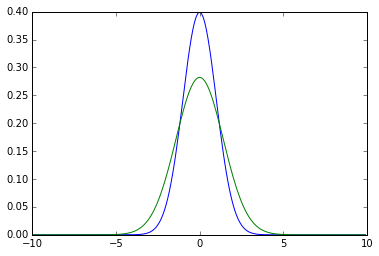

In [27]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) 
xx = np.arange(-10., 10., 0.1)
plt.plot(xx, scipy.stats.norm.pdf(xx));
yy = np.sqrt(scipy.stats.norm.pdf(xx))
yy = yy / (np.sum(yy)*0.1)
plt.plot(xx, yy);

#### We say that a chain sampling the posterior raised to the power $1/T$ has a temperature $T$. Chains with a higher temperature can move around more easily. The only problem is that they aren't sampling the distribution we care about unless $T=1$.

#### With [parallel tempering](https://en.wikipedia.org/wiki/Parallel_tempering), we run several chains that sample the posterior with different temperatures, one with $T=1$ and the others with $T>1$. The chain with $T=1$ produces samples that we can use for inference, while the other chains can more easily explore the posterior and e.g. discover additional modes. A modified Metropolis-Hastings update occasionally allows the chains to exchange positions, giving the $T=1$ chain a mechanism for sampling regions of parameter space it might otherwise have low probability of proposing.

## Hamiltonian Monte Carlo aka Hybrid Monte Carlo

#### While standard MCMC is analogous to the evolution of a thermodynamic system, HMC is (almost) analogous to the evolution of a single particle. Consider our free parameters as coordinates of a position, $\theta$, and minus the log-posterior as a potential energy, $U(\theta)$. HMC introduces momentum parameters, $\phi$, corresponding to each position parameter, and an associated "kinetic energy",
$K(\phi) = \sum_i \frac{\phi_i^2}{2m_i}$.

#### Looking at the analogy the other way, the probability associated with $K(\phi)$ is a multivariate Gaussian with a width given by the "masses". The HMC algorithm alternates Gibbs samples of $\phi|\theta$ with joint updates of $\phi$ *and* $\theta$:
1. Generate a sample of $\phi$ from the distribution defined by $K(\phi)$.
2. Evolve $(\theta,\phi)$ for some time as a dynamical system, according to $K(\phi)$ and $U(\theta)$.
3. The state at the end of this process is the proposal. Apply the standard Metropolis acceptance test to the initial and proposed probabilities $e^{-(K+U)}$. (This is trivial if we conserve energy in the "evolution" phase, but in practice it is often done more approximately to save cycles.)

There's a lot more literature on HMC than we can cover - see e.g. [this chapter](http://www.mcmchandbook.net/HandbookChapter5.pdf). In a nutshell, the introduction of "momentum" into the evolution of the chain is supposed to reduce the autocorrelation, speeding convergence.

## Nested Sampling


#### This method is primarily aimed not at sampling the posterior distribution by at calculating the Bayesian evidence, the integral of the likelihood function over the prior, $\int P(D|\theta)\,P(\theta)d\theta $ (more on this in session 6). However, to calculate the evidence accurately requires a very good map of the posterior, and so the method can also be used to produce posterior samples that can be analyzed in the same way as traditional MCMC samples.

#### The algorithm also fundamentally differs from those above in that it evolves an ensemble of points in parameter space instead of a single point. It begins with a large number of points sampled from the prior, and gradually evolves them towards higher-likelihood positions, keeping track of how the volume filled changes. The evidence can then be calculated as $\int_0^1 L(V)\,dV$ (or rather a numerical approximation thereof). By virtue of spamming the parameters space with points at the start, nested sampling is likely (though never guaranteed) to find multiple modes, if they exist.

#### The computational challenge here is to maximize the efficiency of moving a given point to a position of higher likelihood. Math is involved - see e.g. the [`MultiNest` paper](http://arxiv.org/abs/0809.3437).

# Affine-Invariant Sampling

#### This refers to a class of methods for evolving an ensemble of points in parameter space such that, after convergence, they can be regarded as samples from the target distribution. The currently fashionable variant is coded in a `python` package hilariously called `emcee`, and implements the evolution rule proposed by [Goodman and Weare (2010)](http://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-p.pdf). The algorithm for moving an individual point in the ensemble is quite simple:
1. Randomly pick a different point from the ensemble (total size $N$).
2. Propose a move in the direction of that point, by the distance between them multiplied by a random from this distribution:
$g(z) \propto \frac{1}{\sqrt z}; ~ \frac{1}{2}\leq z \leq 2$
3. Accept or reject the move based on the ratio of posterior densities multiplied by $z^{N-1}$.

#### Note that there is some magic in the density $g$. The 2 can be replaced by another number, but we are not free to choose just any function there.

#### The main attraction of this algorithm seems to be ease of use of the `emcee` package and the lack of forethought/tuning needed compared with non-super Metropolis. Points can also move more freely throughout highly nonlinear degenerate regions compared with Metropolis-like steps, although jumps from one end of a banana to the other or between well separated modes will still be unlikely. A downside is that convergence can be very slow if the ensemble is not started in a region of high probability.